# Centroid Vetting Example

Transit-like signals can be created when unresolved eclipsing binaries and other variable sources are present on the detector. One method of determining whether the transit signal was from the target or the background is by measuring the centroid of the light. If the centroid is not on the target there is a likelihood of the transit being a False Positive (Kostov et al. 2019, apj 157:124 section 2.1). 

`Exovetter.Centroid` returns the average offset and significance that it is on the target. You get several plots showing the out of transits, in transit and difference image. The centroids of each are measured using a Gaussian. For the OOT and In-Transit, the centroid is constrained to the central +/-1pixel in box row and column direction. 

In [1]:
from exovetter.tce import Tce
from exovetter import vetters as vet
from exovetter import const as exo_const
from exovetter import utils
import lightkurve as lk
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.max_open_warning'] = 0 # Centroid makes a lot of figures for short period transits so this warning can optionally be silenced


## Setup and Vetting
Exovetter vetting alogrithms usually use TCE and lightkurve objects as input. The Centroid Vetter however requires a Target Pixel File objects from lightkurve. Here we will show two examples, one with no offset and another with a small but possible offset.

#### TCE with a negligible offset (the known planet WASP-18 b we have used in the other notebooks)

In [2]:
period = 0.94145223 * u.day
epoch = 1354.4579 * u.day
epoch_offset = exo_const.btjd
depth = 0.00931894 * exo_const.frac_amp
duration = 0.08932 * u.day

wasp_18b_tce = Tce(period=period, epoch=epoch, epoch_offset=epoch_offset, 
                   depth=depth, duration=duration, comment='example')

# Download the relevent target pixel file for this tce
wasp_18_tpf = lk.search_targetpixelfile('WASP-18 b', author='SPOC')[0].download()


# run the centroid vetter with this tce and tpf
wasp_18b_centroid_instance = vet.Centroid()
wasp_18b_centroid_results = wasp_18b_centroid_instance.run(wasp_18b_tce, wasp_18_tpf)
wasp_18b_centroid_results

{'offset': 0.07075009647202368, 'significance': array([0.9571253])}

#### Target with an offset (TOI 565.01)

In [3]:
candidate = "TOI 565.01"
toi_tce = utils.get_mast_tce(candidate)[0]

# Download a relevent target pixel file for this tce
toi_tpf = lk.search_targetpixelfile(candidate)[0].download()

# run the centroid vetter with this tce and tpf
toi_centroid_instance = vet.Centroid()
toi_centroid_results = toi_centroid_instance.run(toi_tce, toi_tpf)
toi_centroid_results

{'offset': 1.2847708138648306, 'significance': array([8.16467305e-126])}

In Centroid, the results are as follows:
* offset : Size of offset in pixels
* significance : The statistical significance of the transit. Values close to 1 mean the transit is likely on the target star. Values less than ~1e-3 suggest the target is not the source of the transit.
           

The following attributes are also available after running the vetter object:
* metrics : Centroid result dictionary.
* tpf : The target pixel file used for the centroid calculations

## Plots
In order to generate diagnostic plots from vetters, we can call the `plot` argument while running or use the `plot` method with the vetter object after it has been run. 

#### TCE with a negligible offset

{'offset': 0.07075009647202368, 'significance': array([0.9571253])}

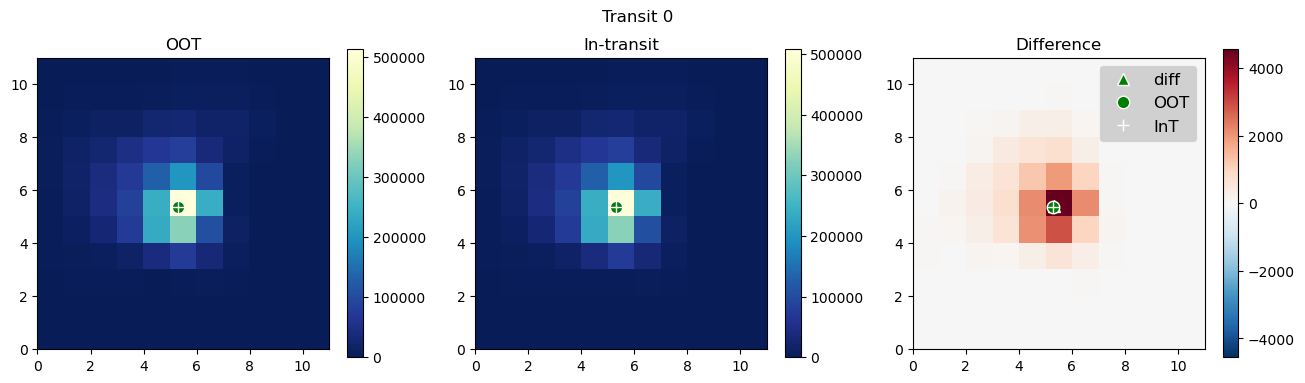

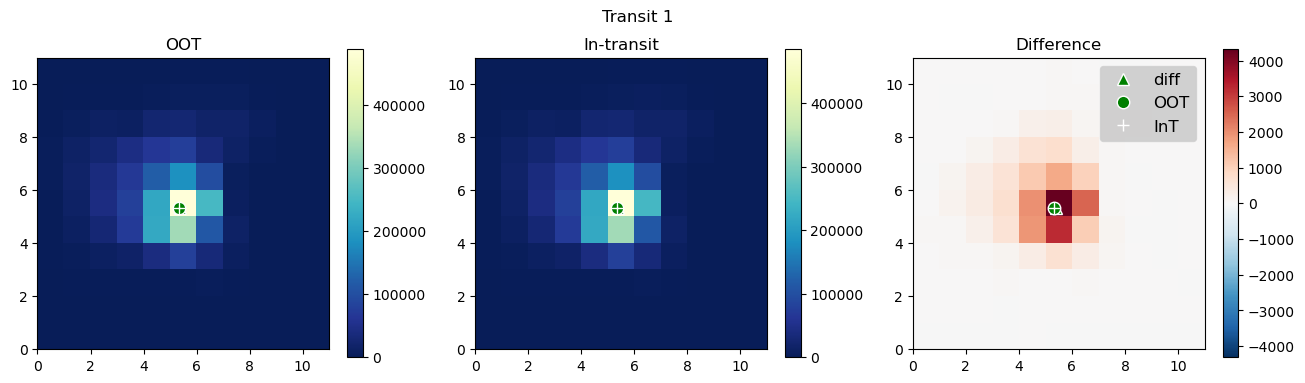

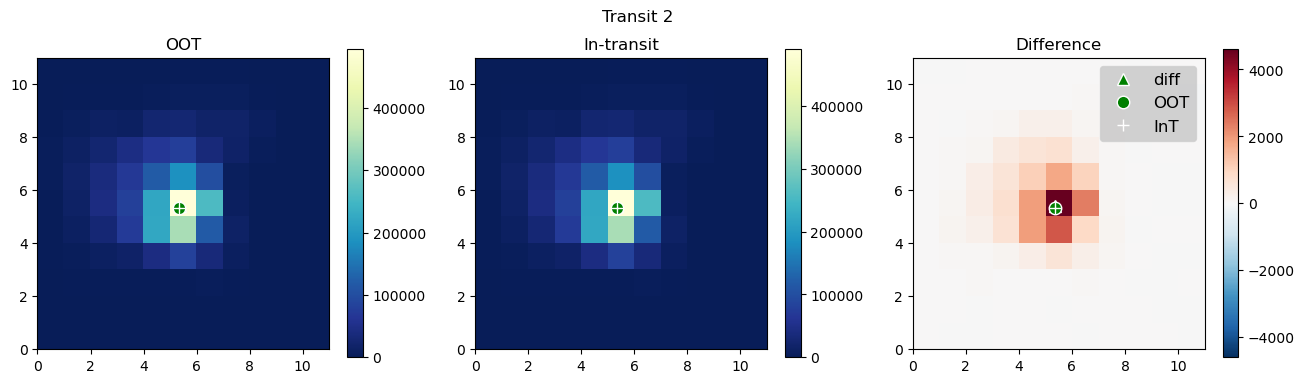

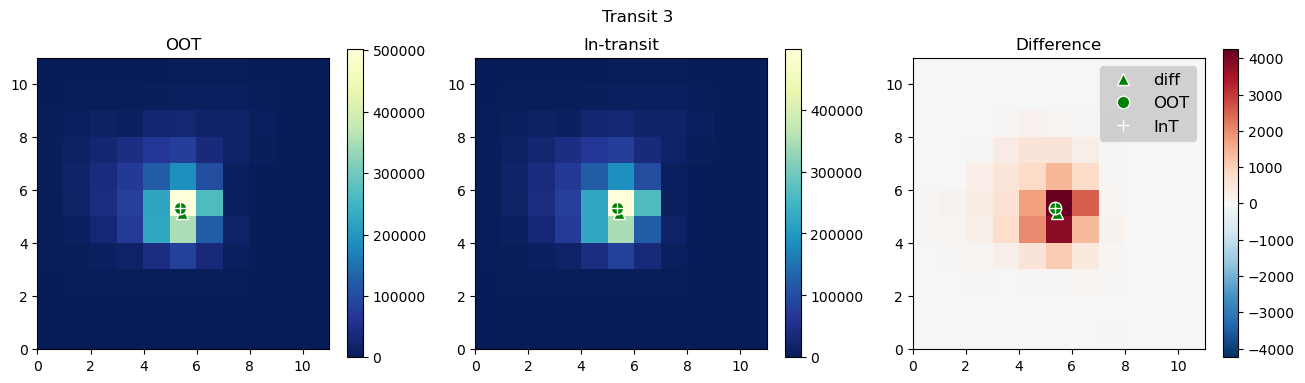

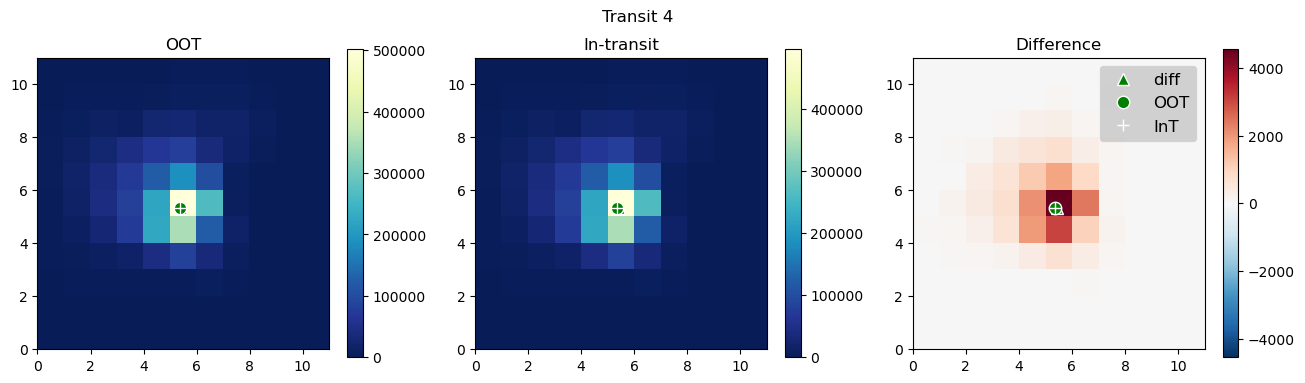

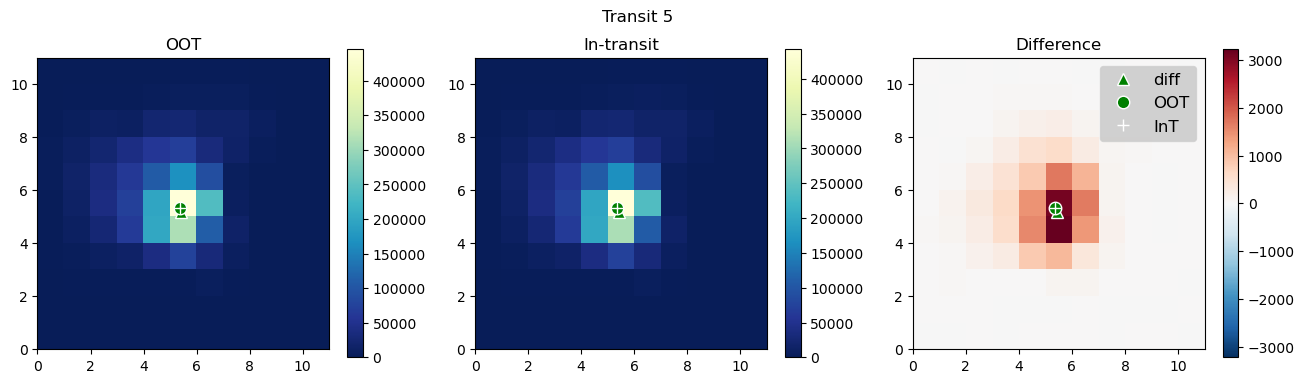

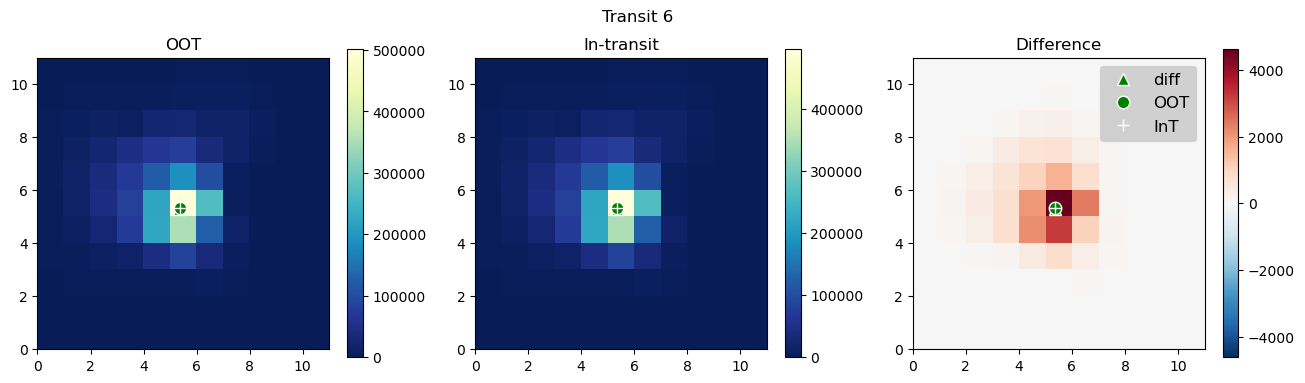

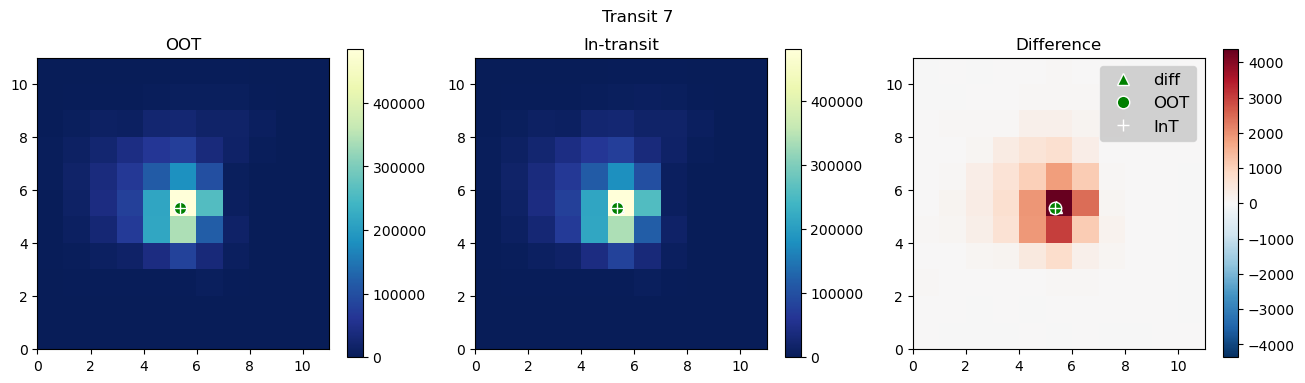

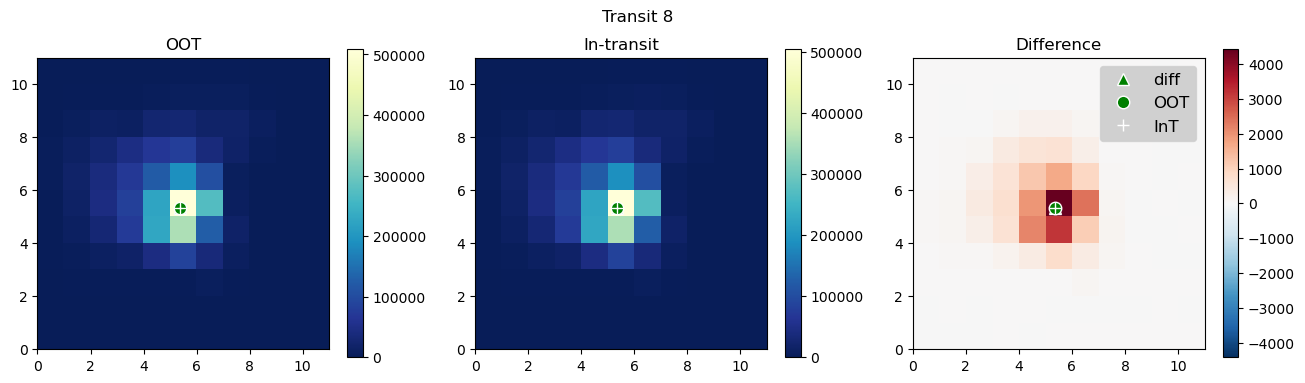

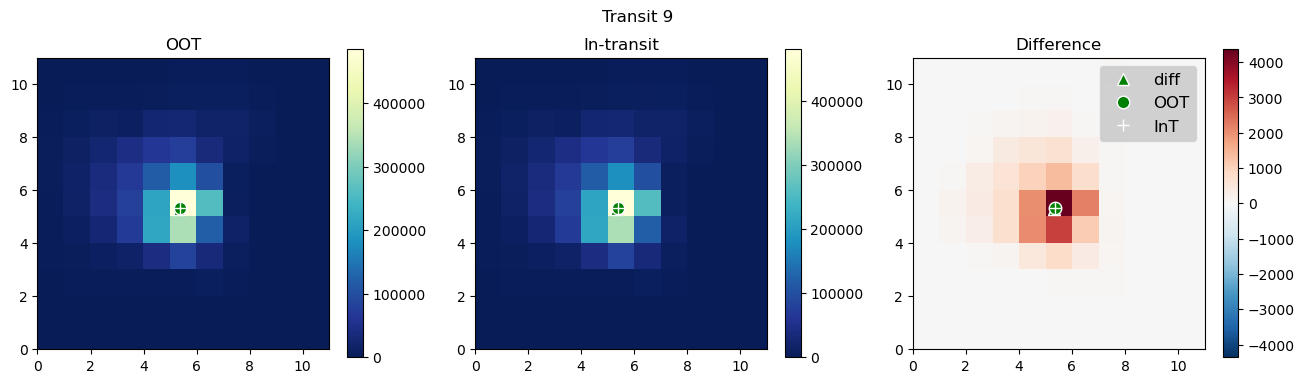

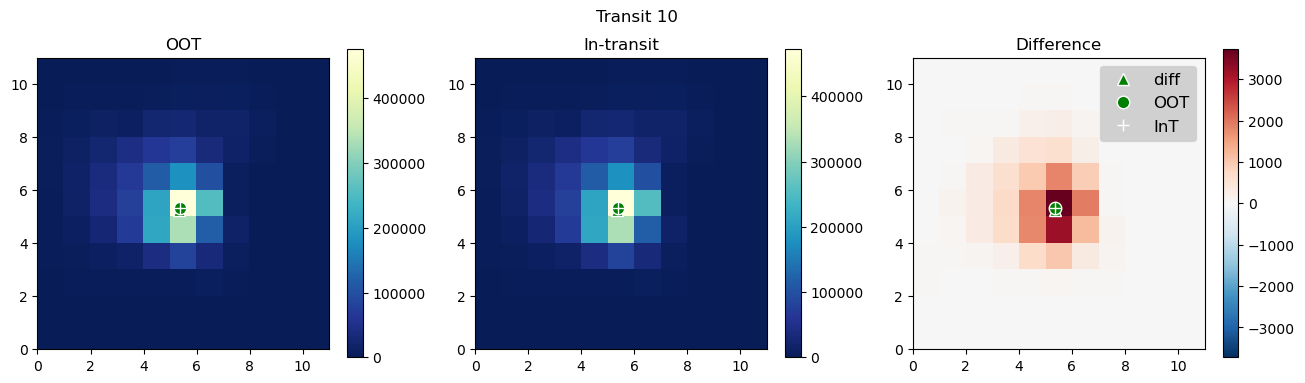

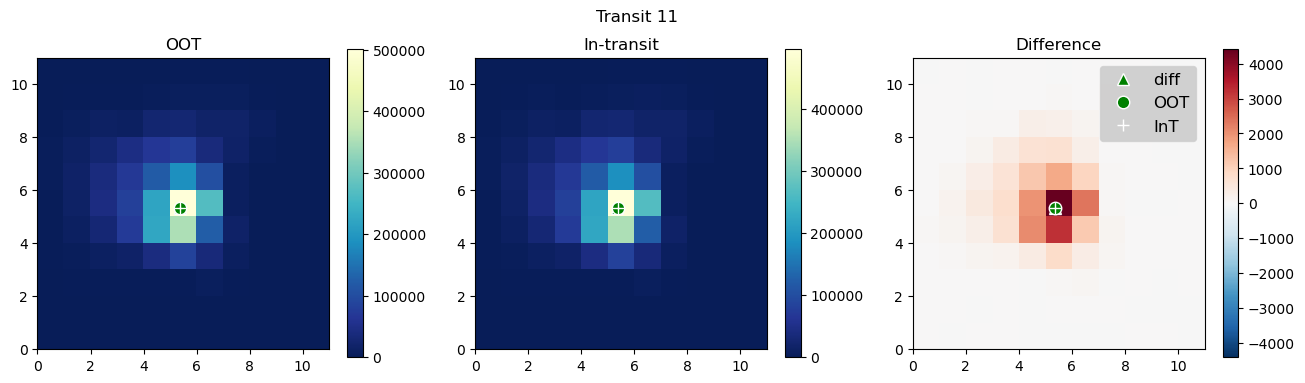

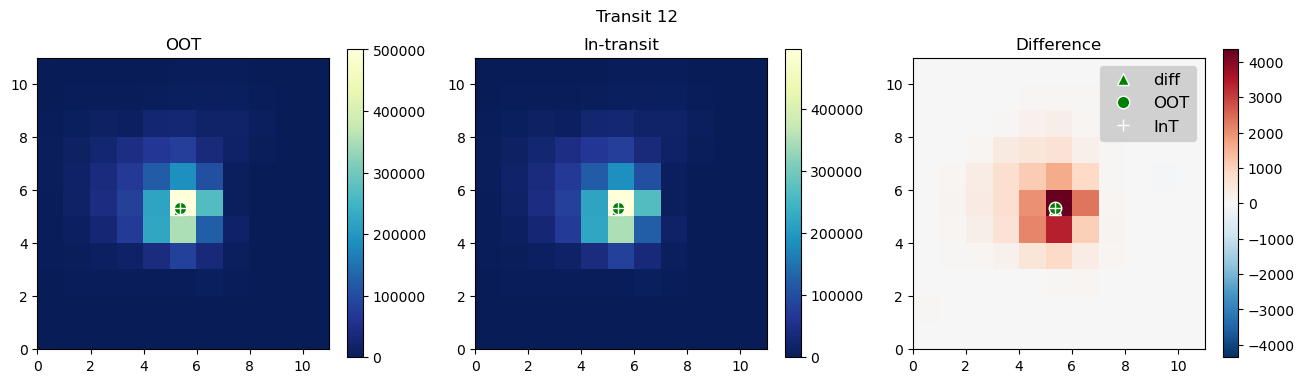

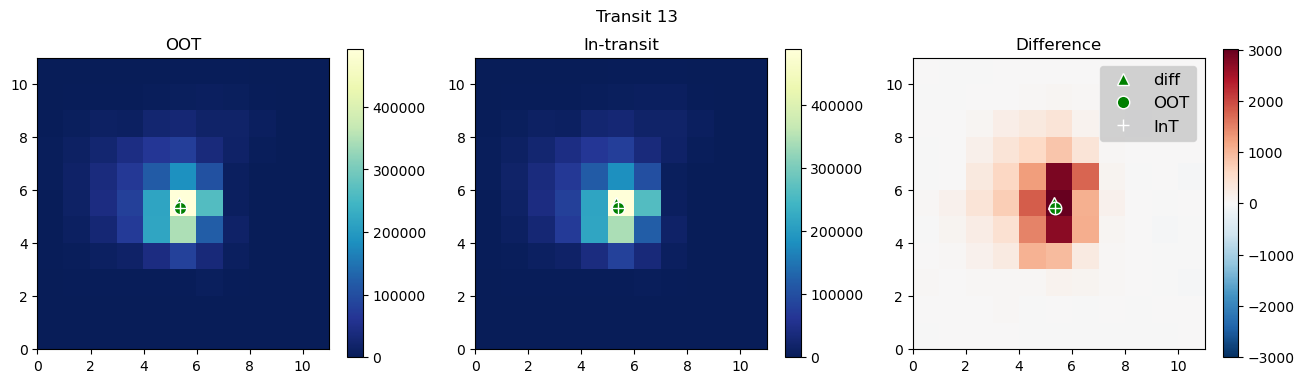

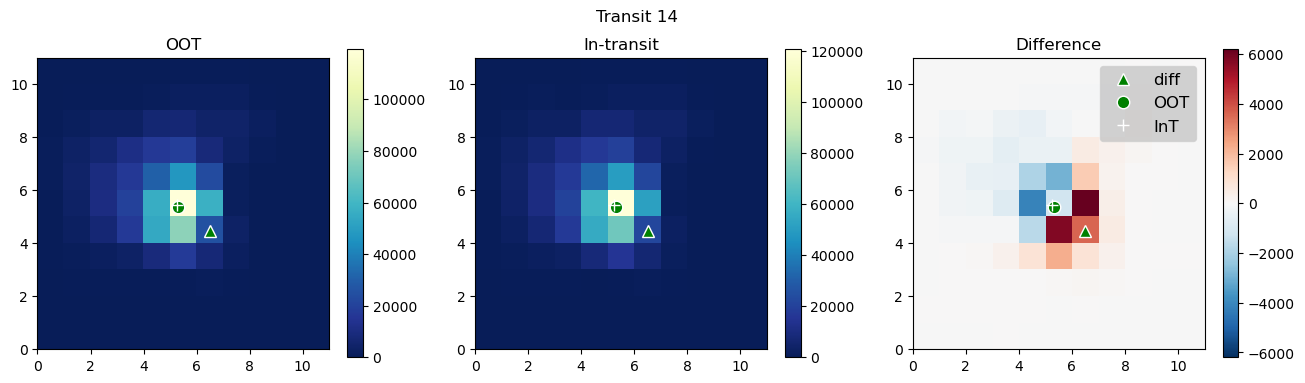

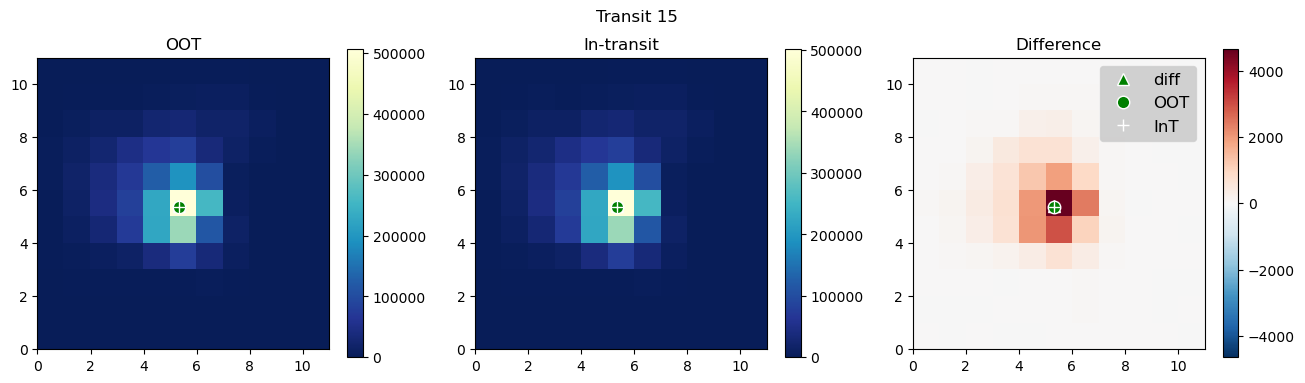

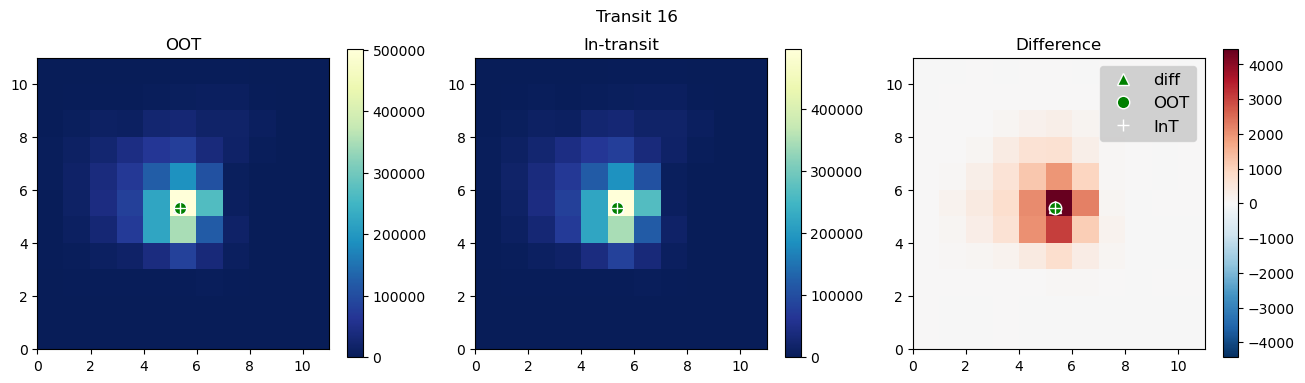

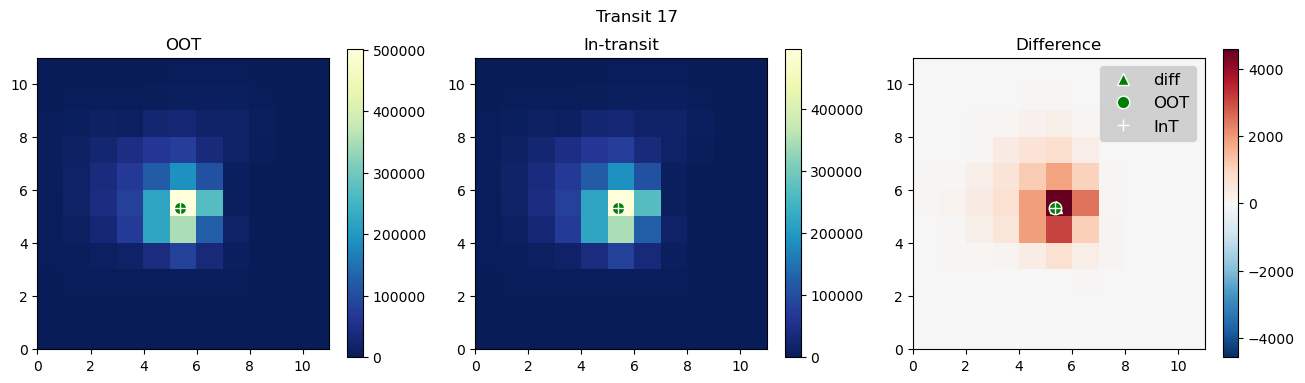

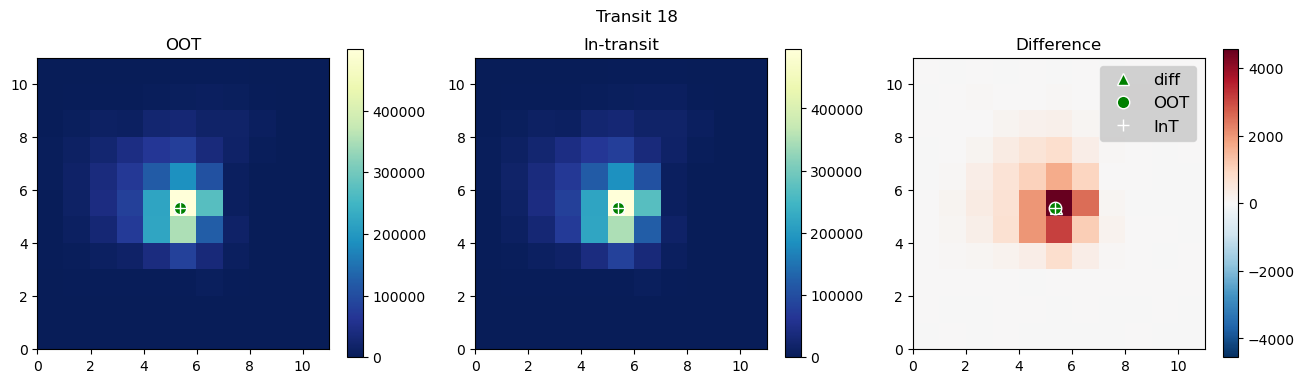

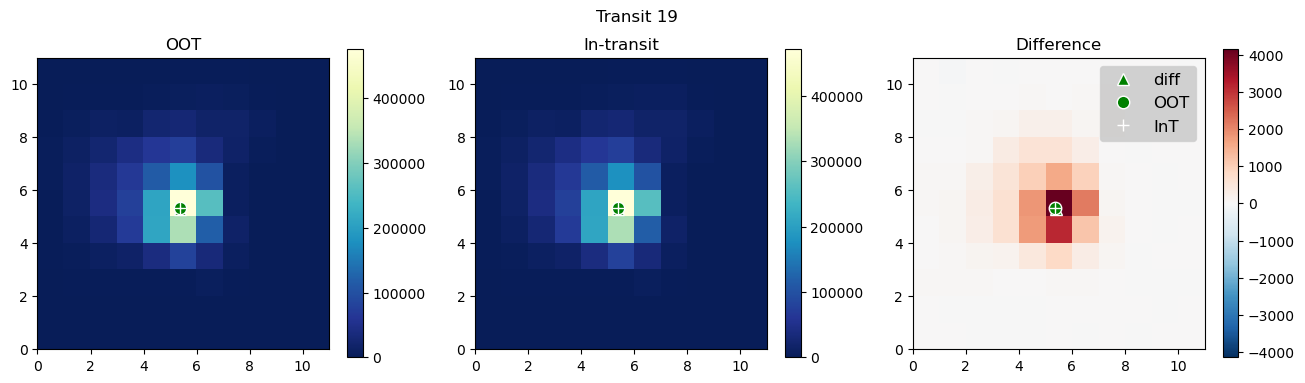

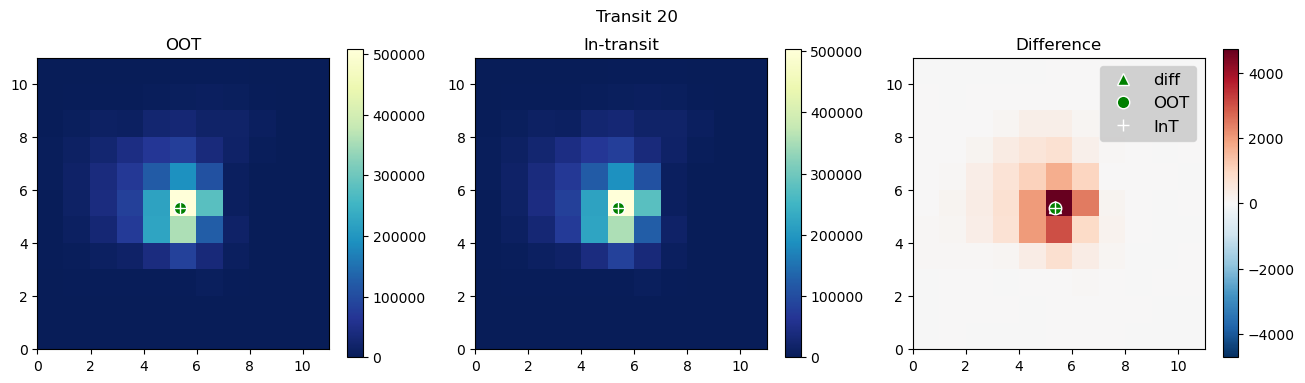

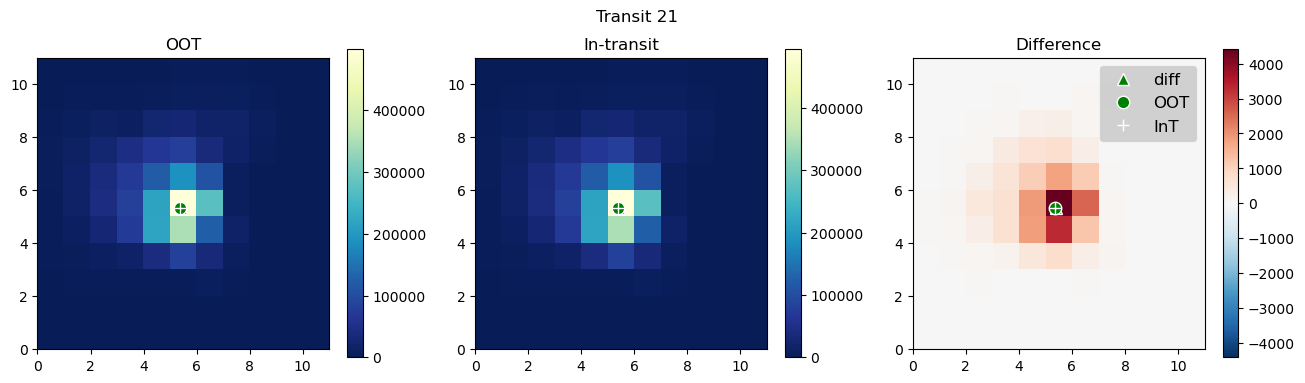

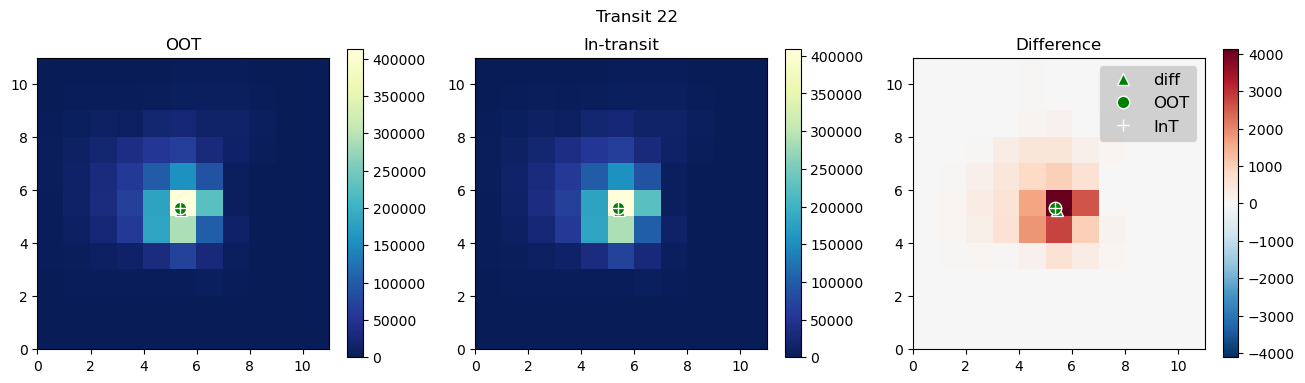

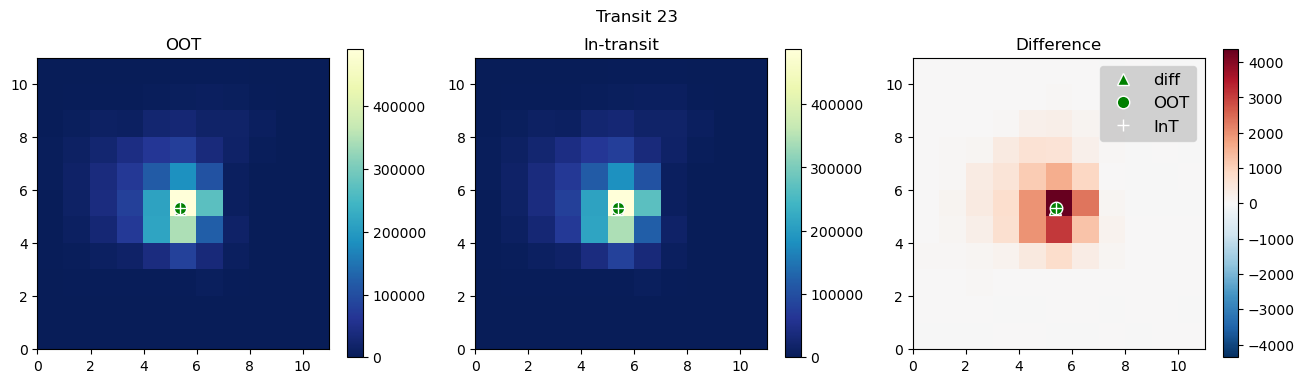

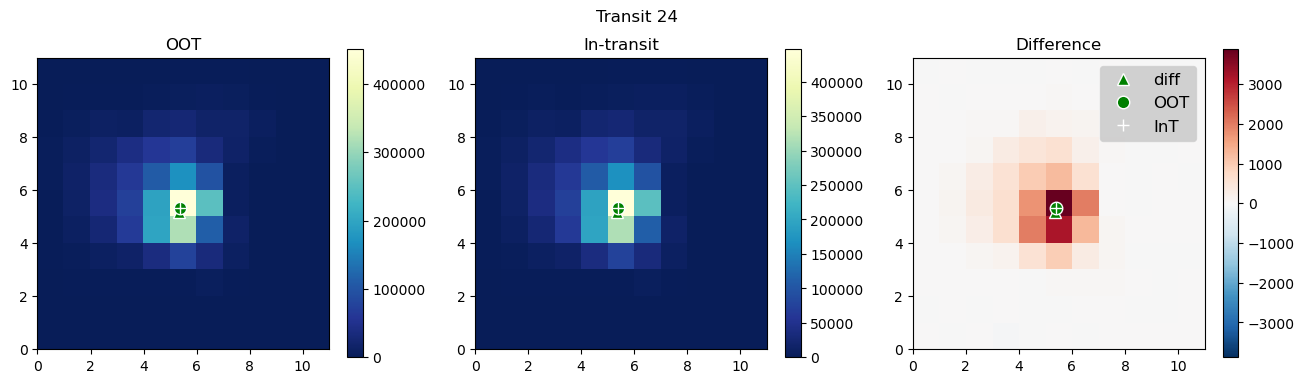

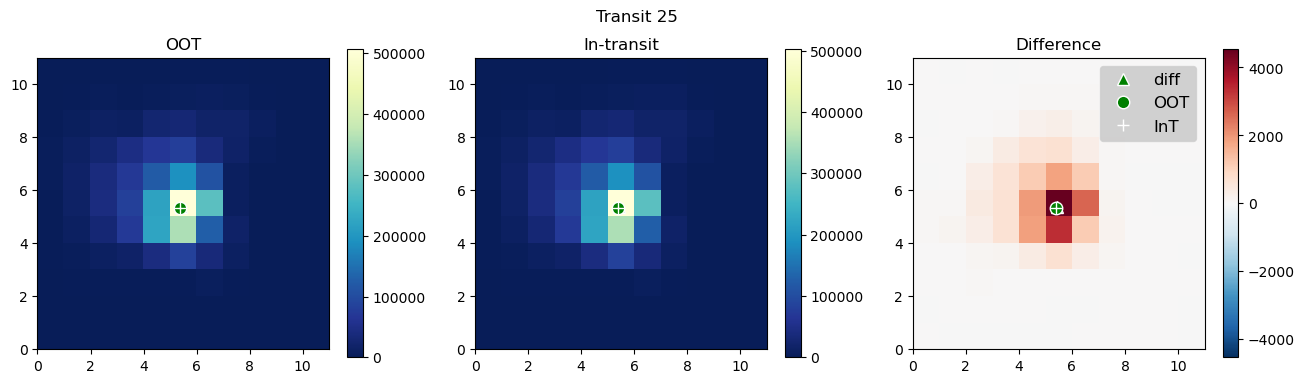

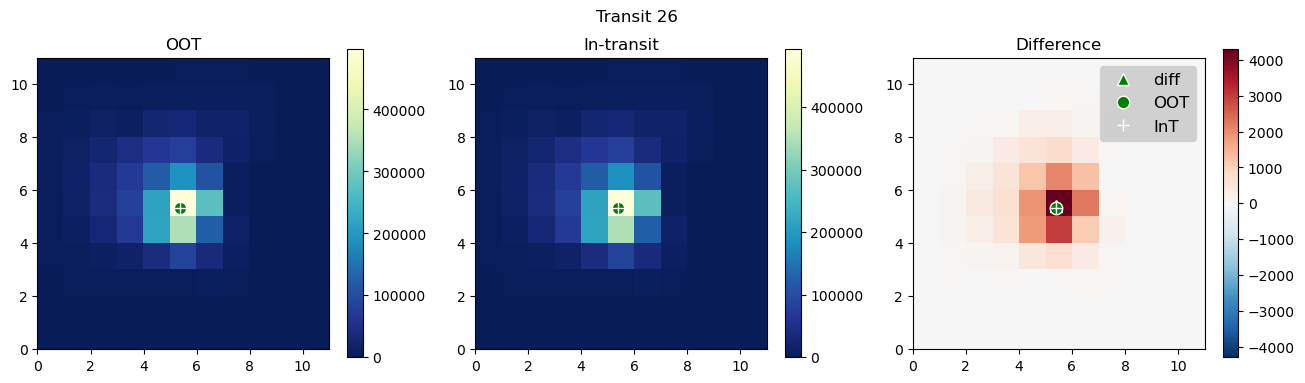

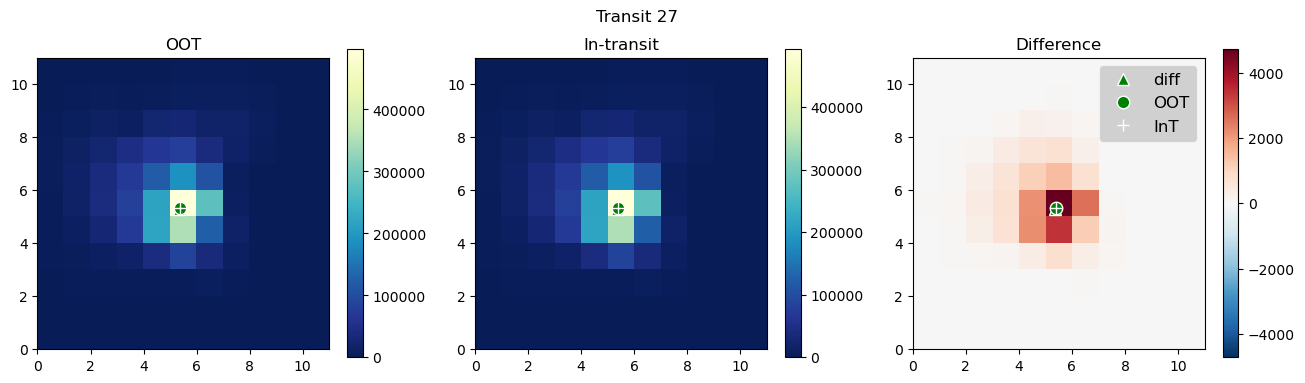

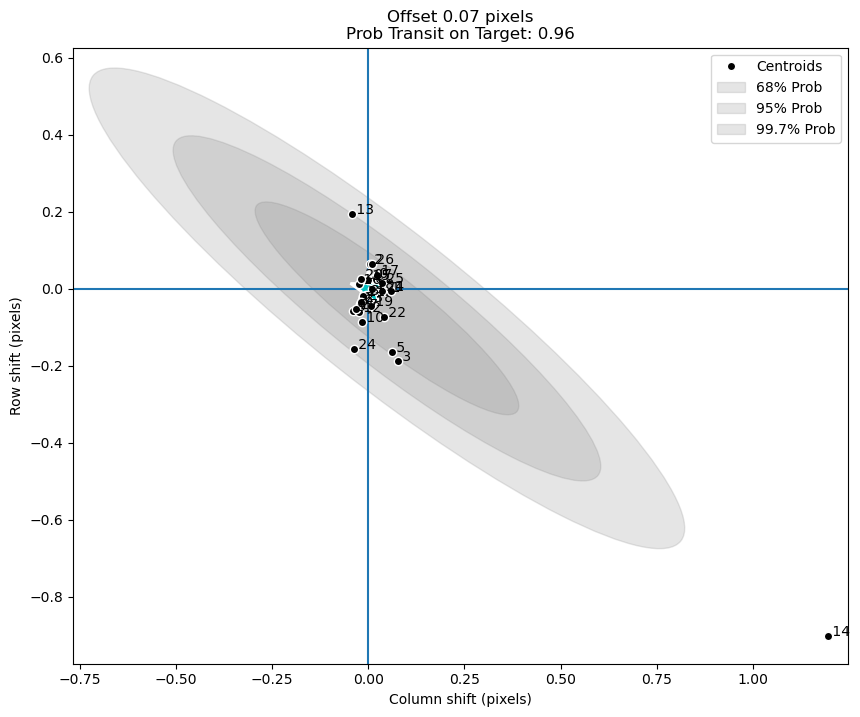

In [4]:
wasp_18b_centroid_instance.run(wasp_18b_tce, wasp_18_tpf, plot=True)

#### Target with an offset

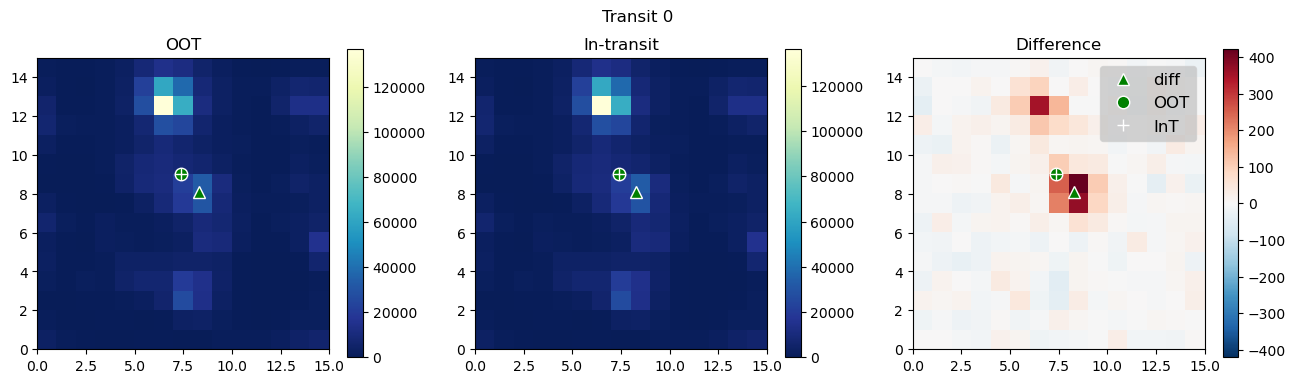

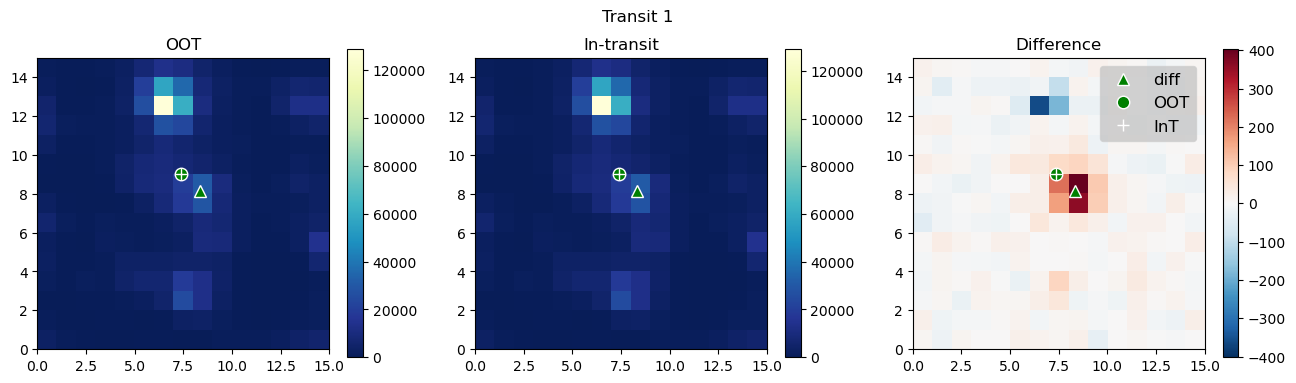

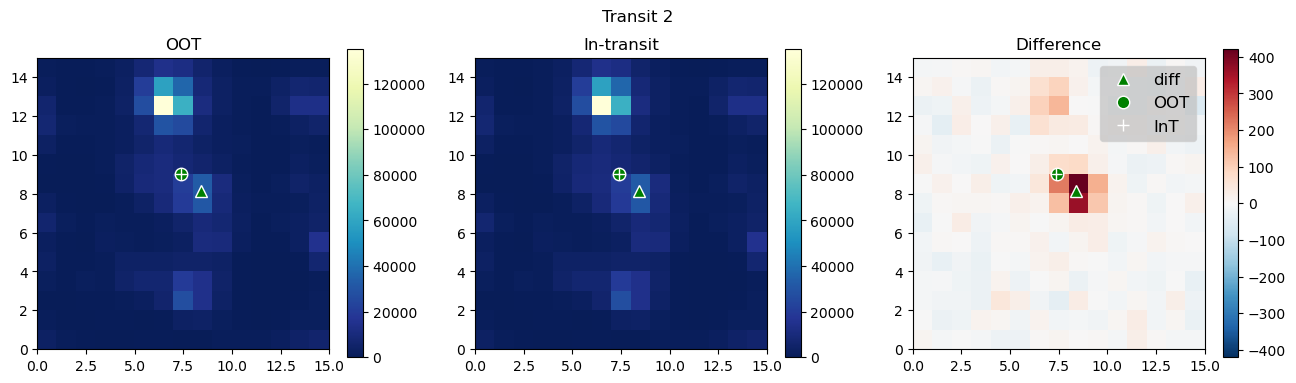

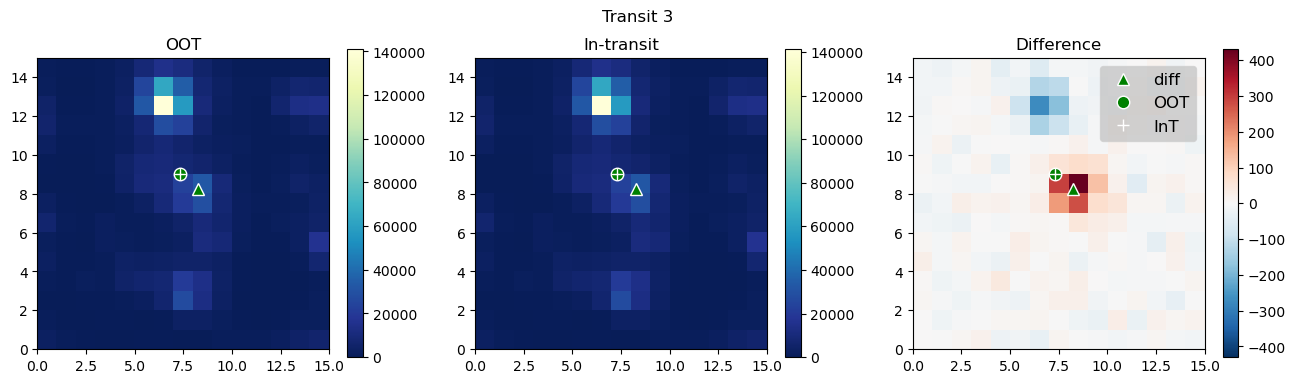

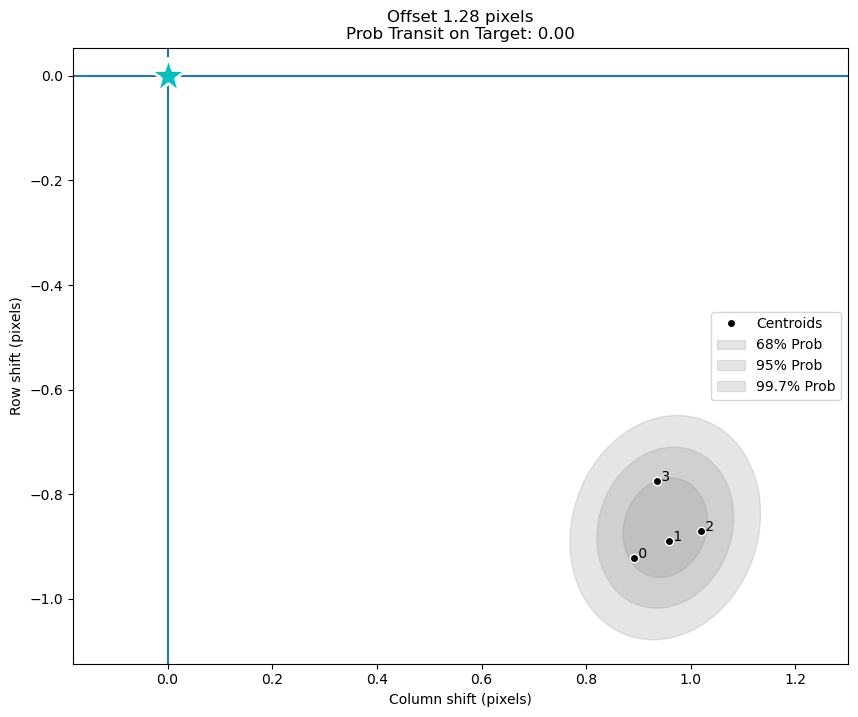

In [5]:
toi_centroid_instance.plot()

The difference and summary ellipse plots can also be called separately to avoid generating too many figures for short period transits:

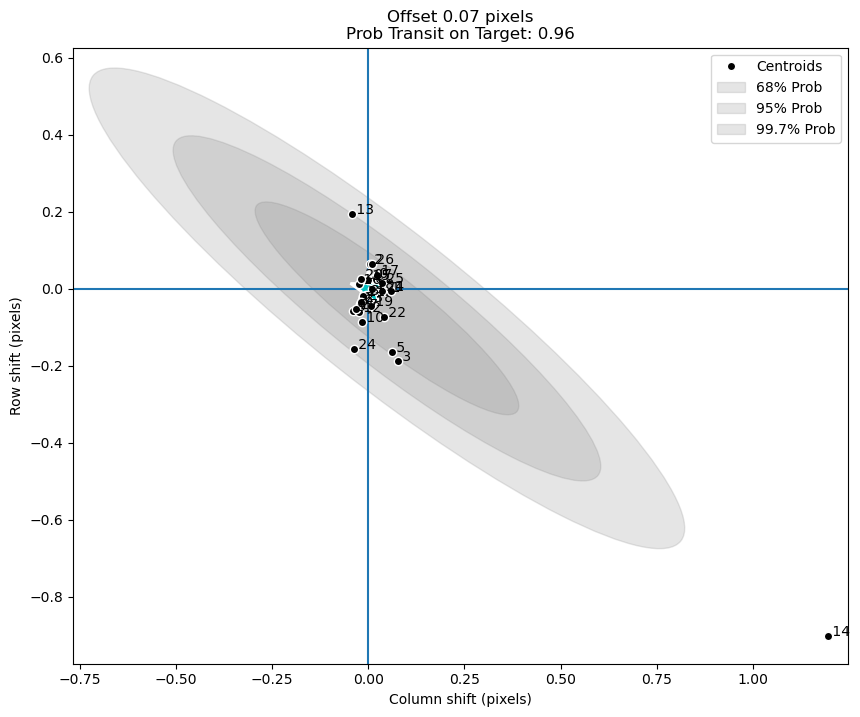

In [6]:
wasp_18b_centroid_instance = vet.Centroid(diff_plots=False, centroid_plots=True)
wasp_18b_centroid_results = wasp_18b_centroid_instance.run(wasp_18b_tce, wasp_18_tpf)

## Additional options
Centroid also has the option to place the pixel coordinates of a desired target star on the tpf image. The resulting difference will be taken from the target star rather than the fit of the out of transit centroid.

{'offset': 0.08657034555447025, 'significance': array([0.94531228])}

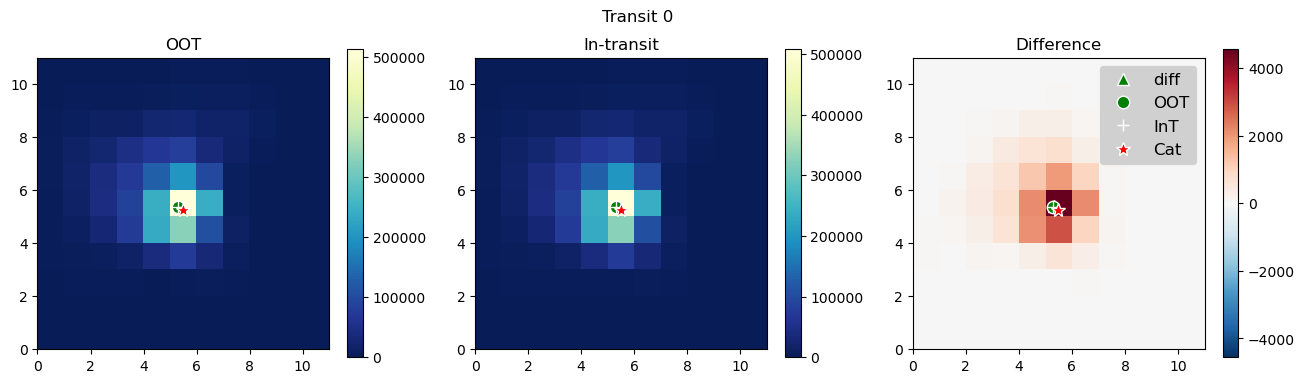

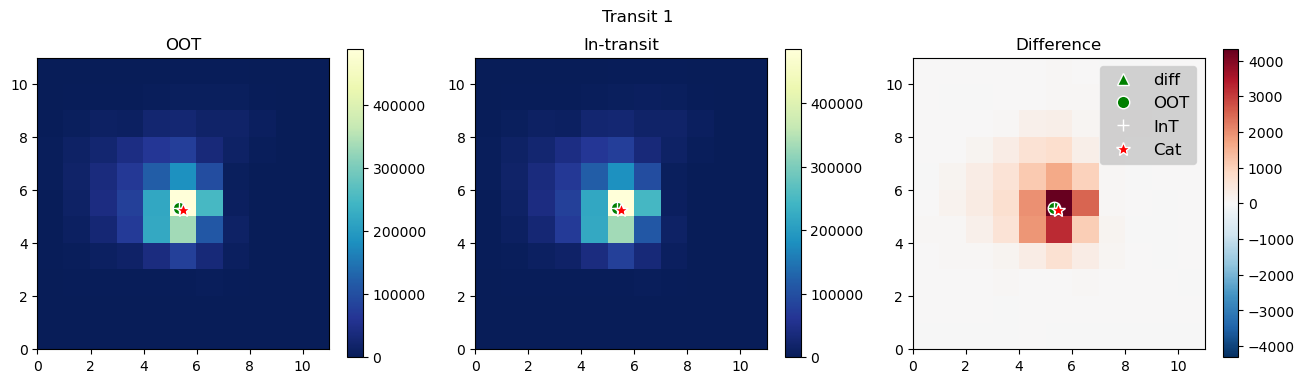

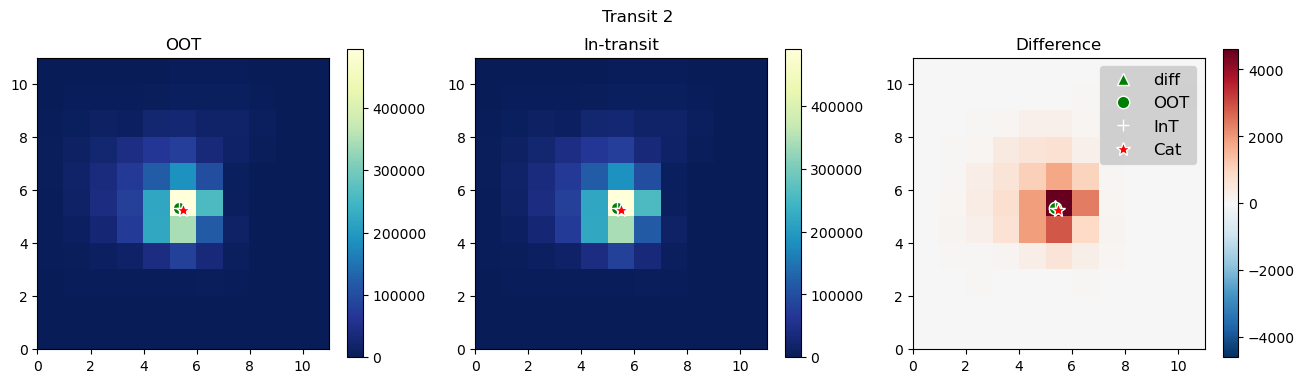

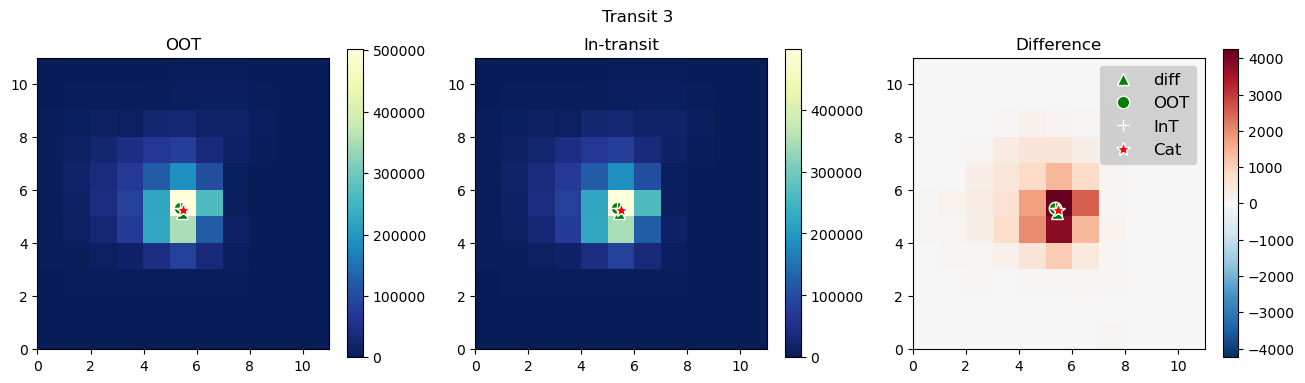

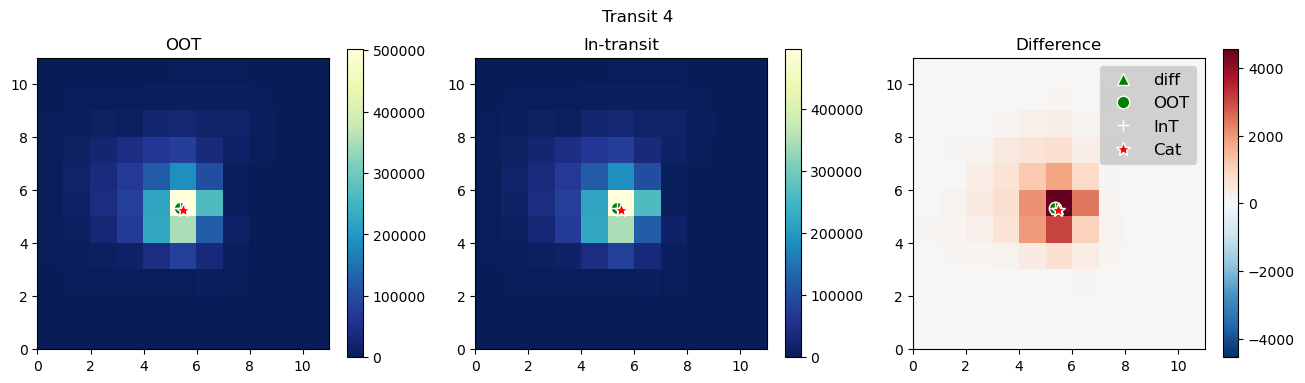

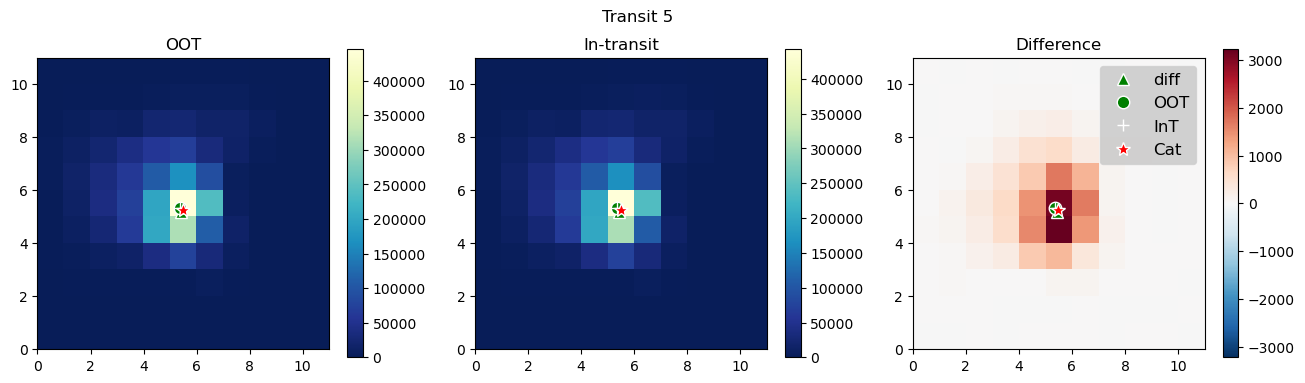

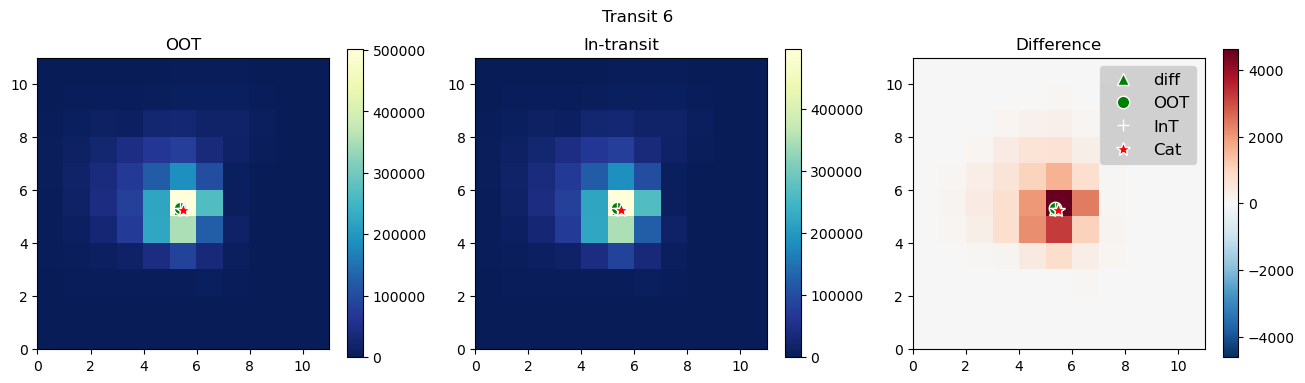

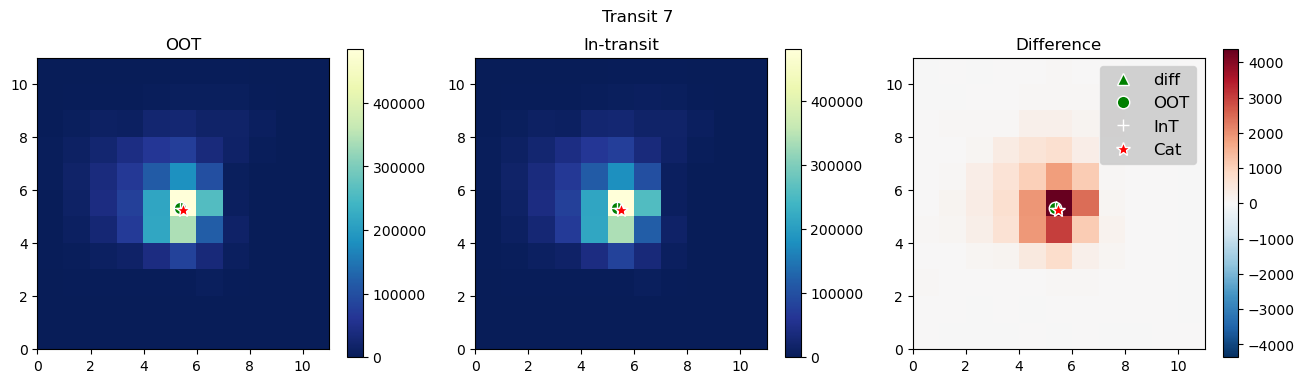

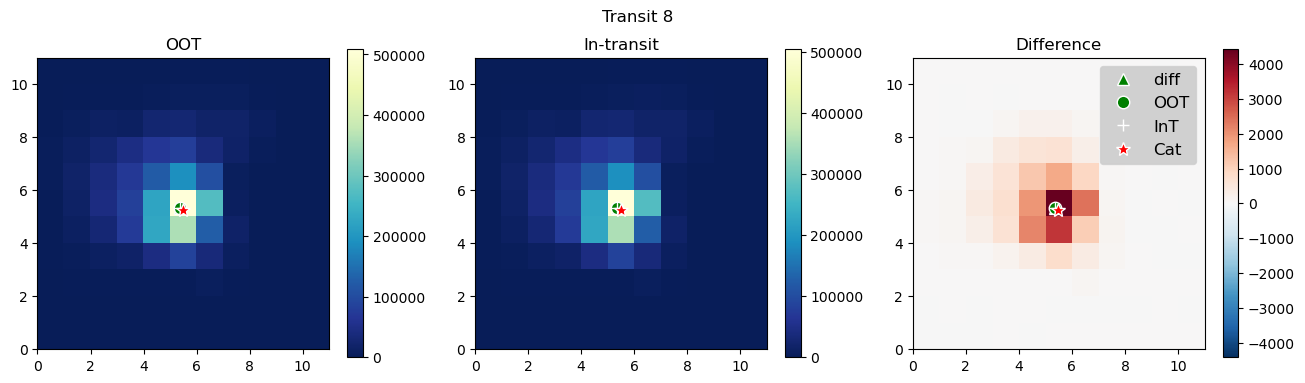

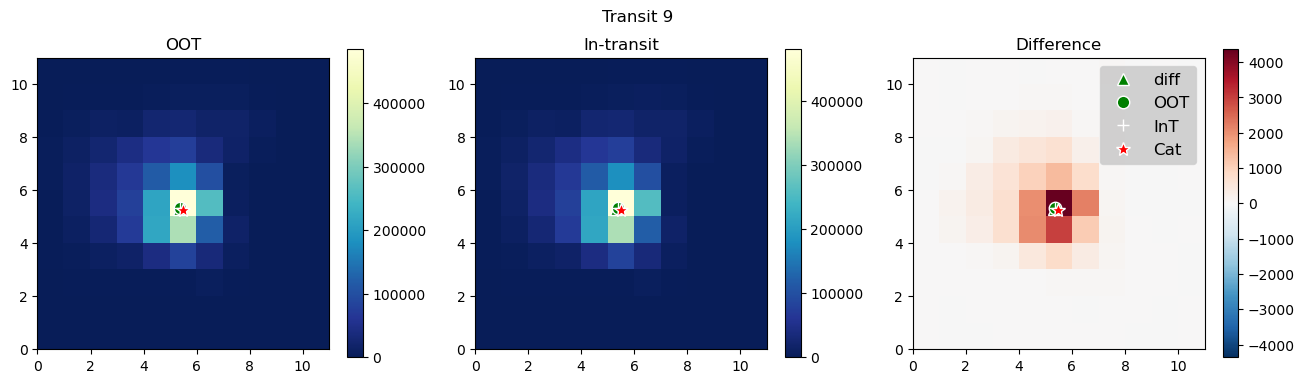

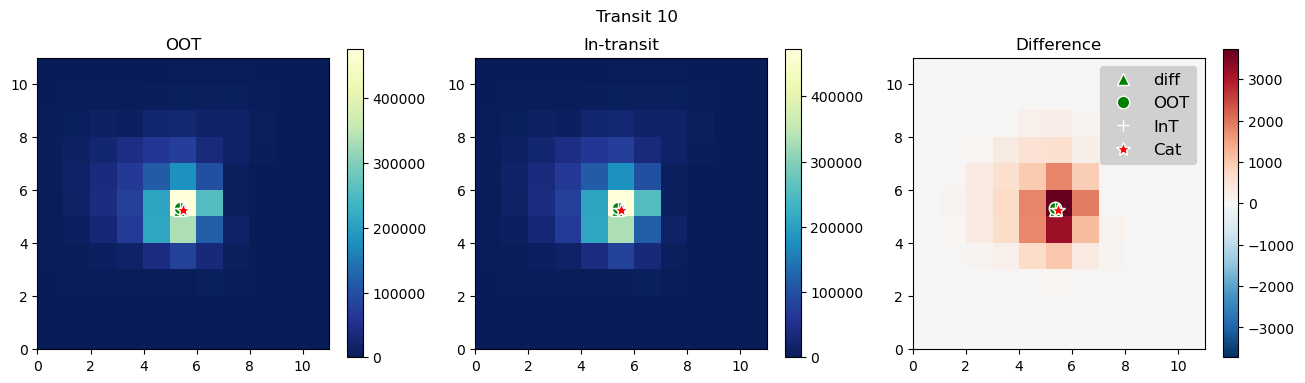

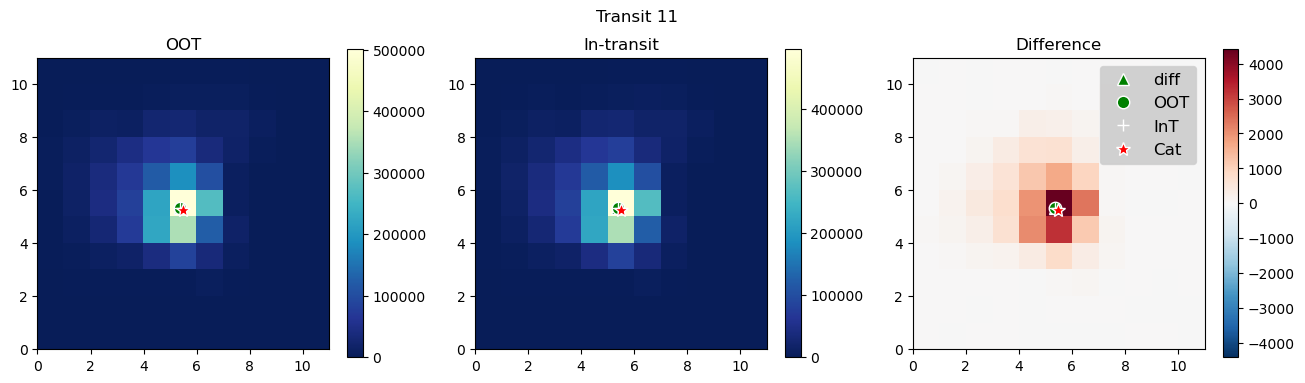

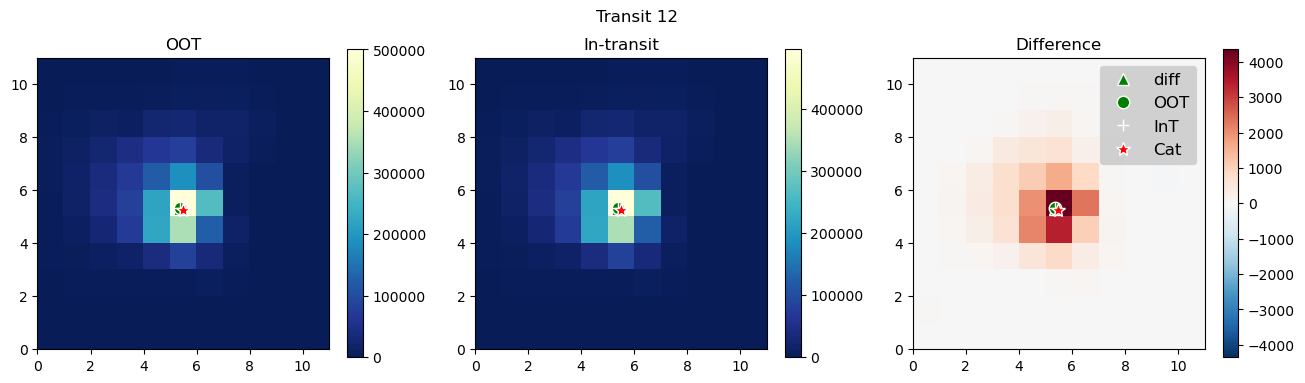

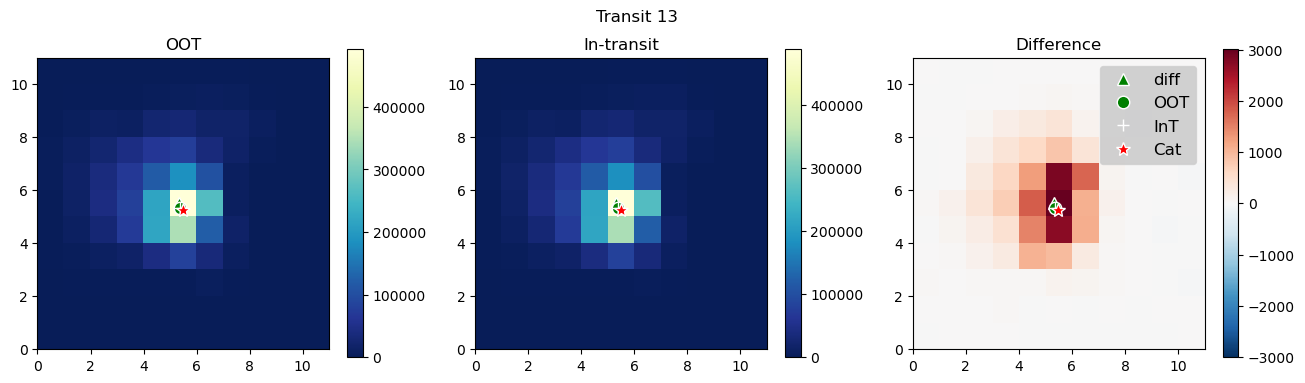

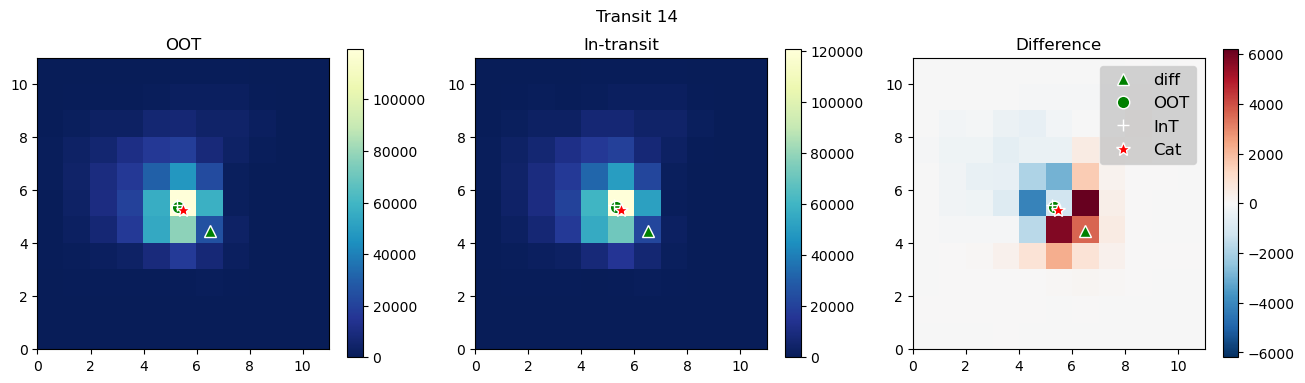

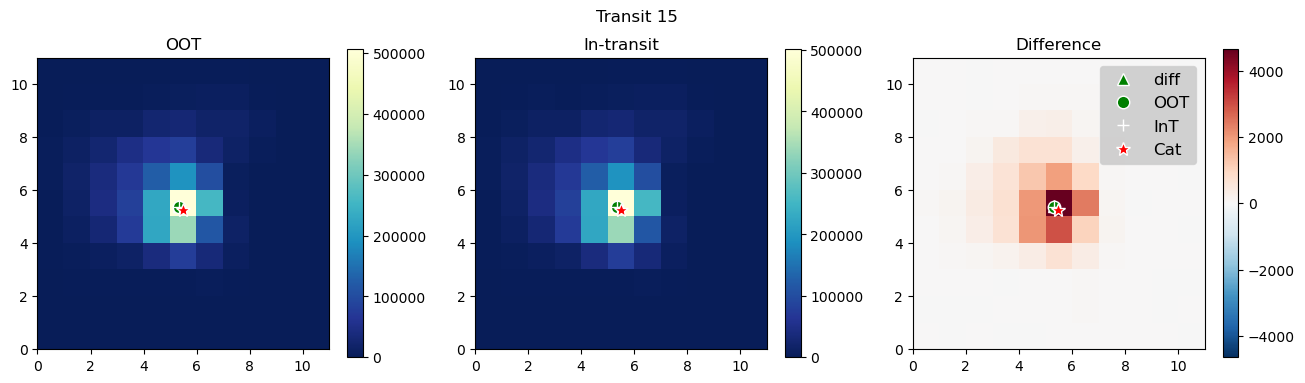

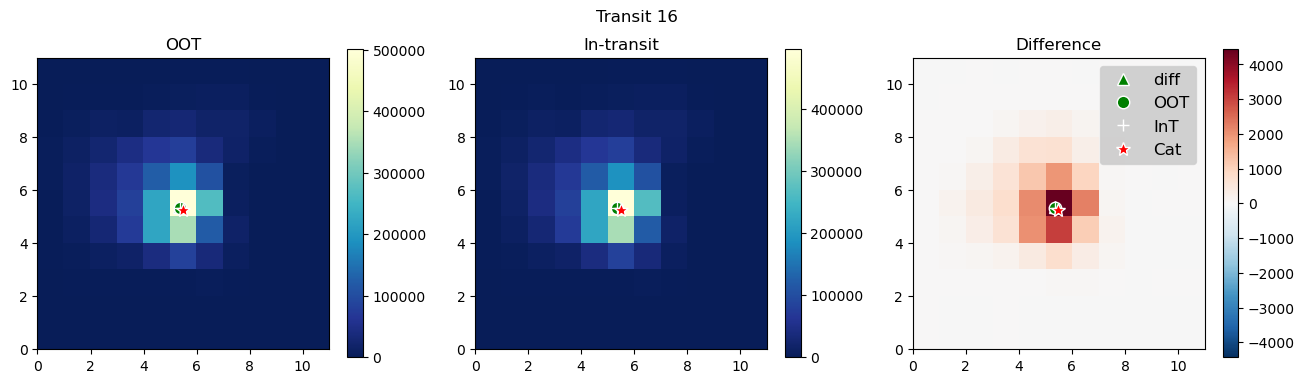

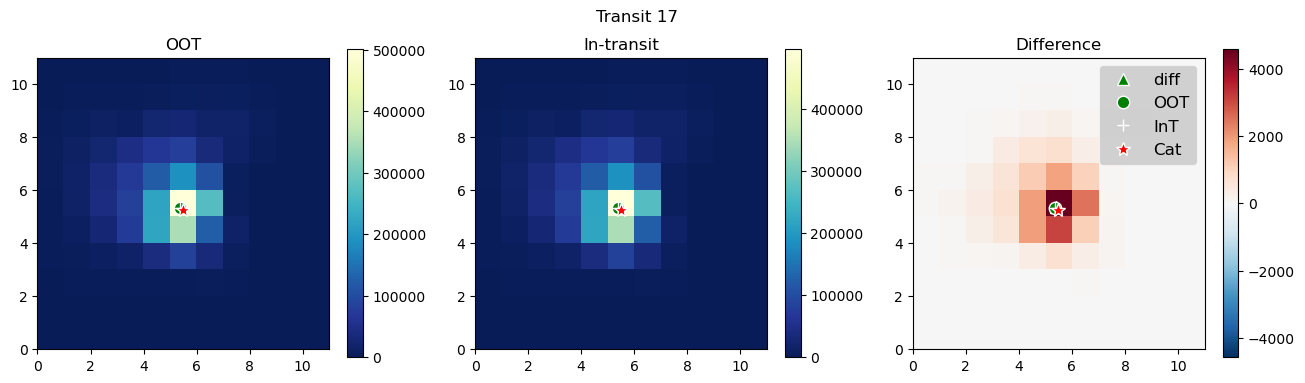

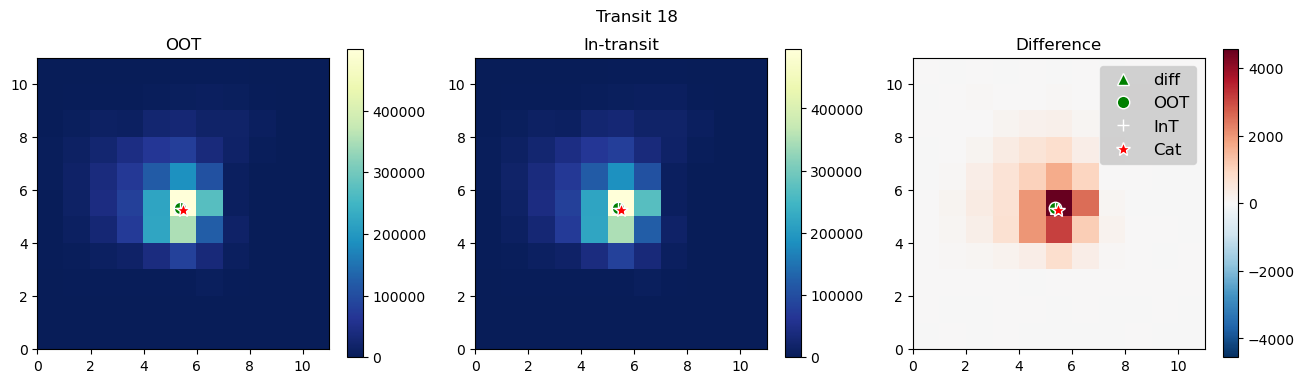

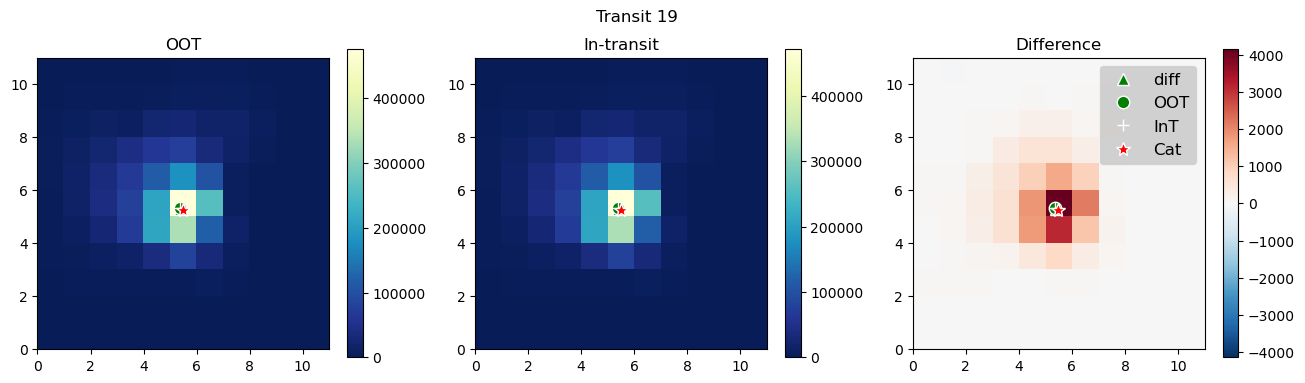

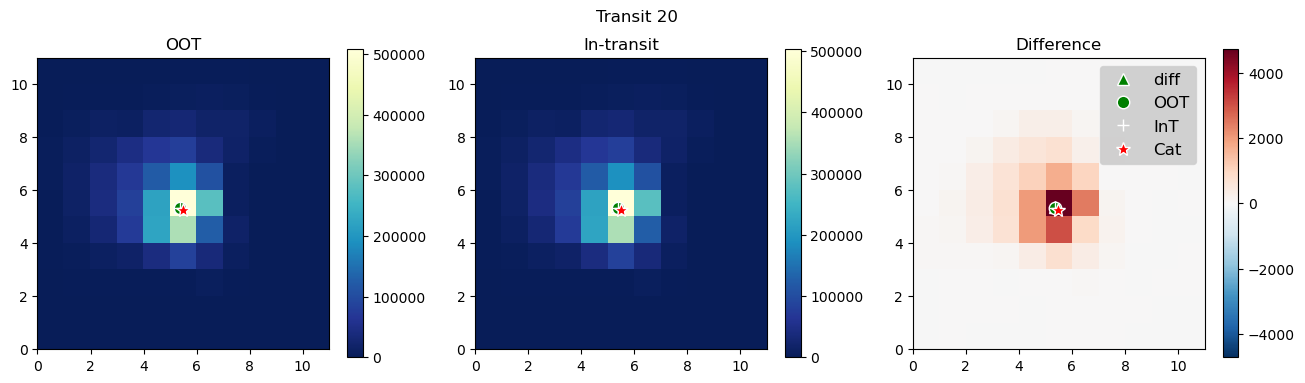

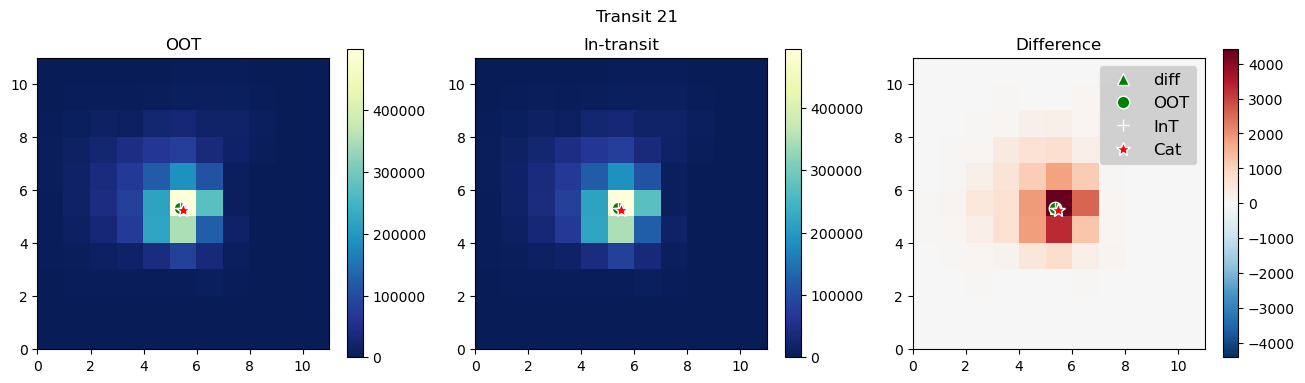

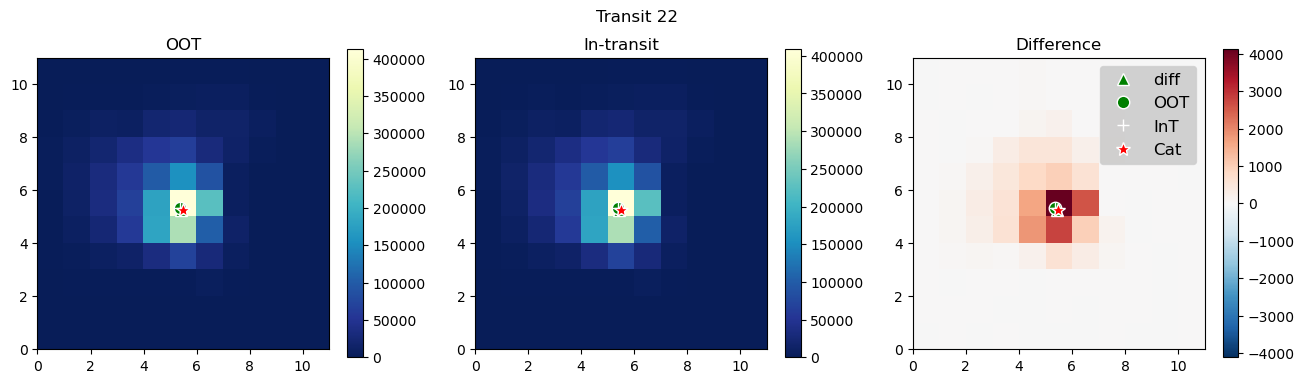

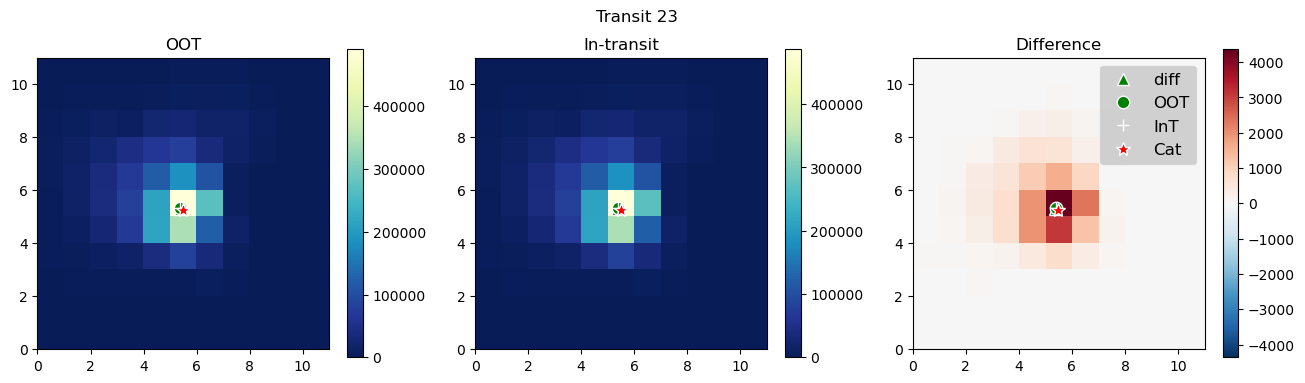

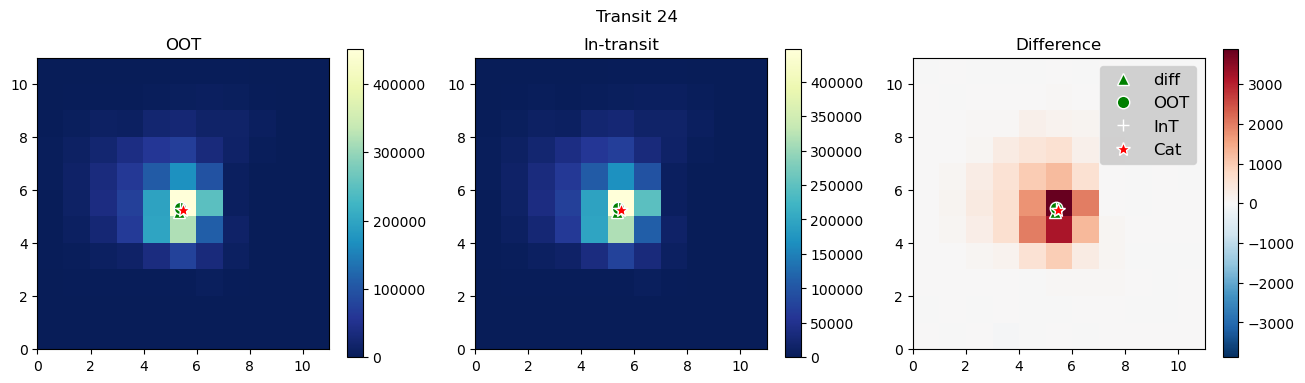

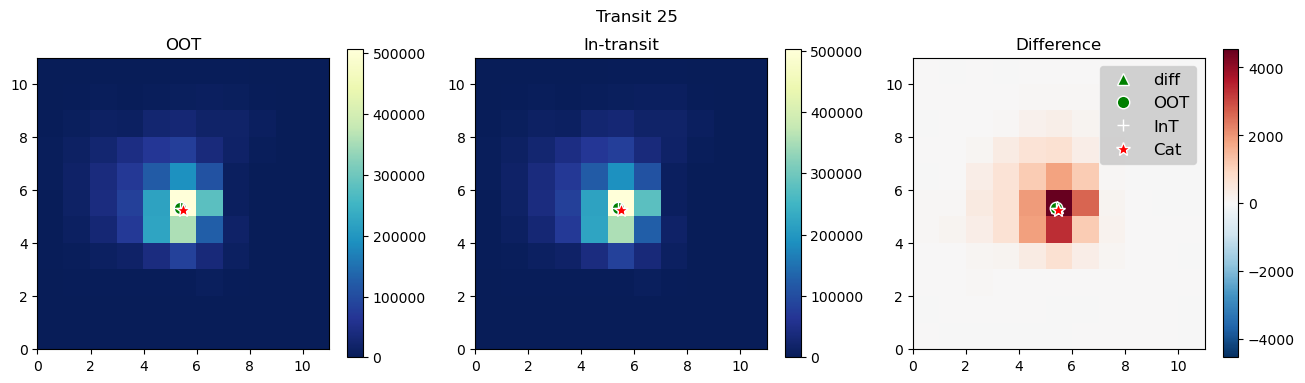

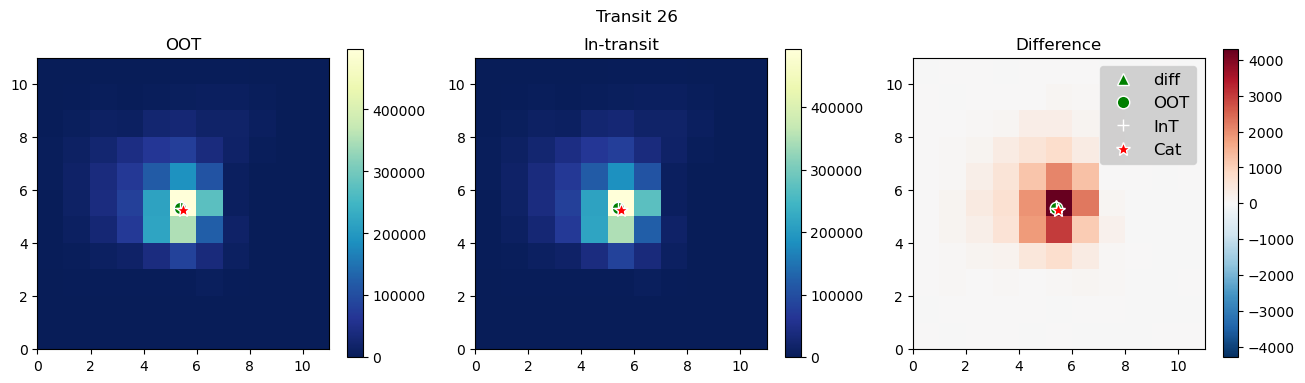

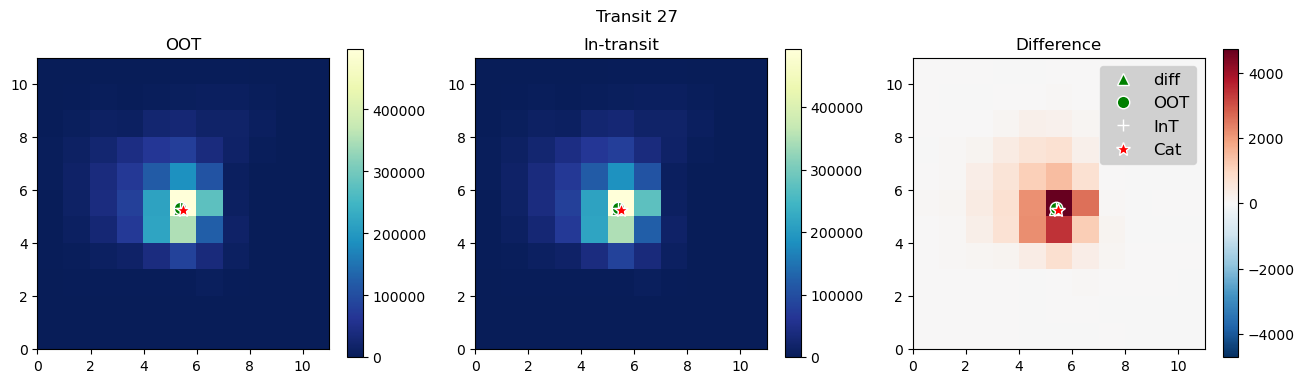

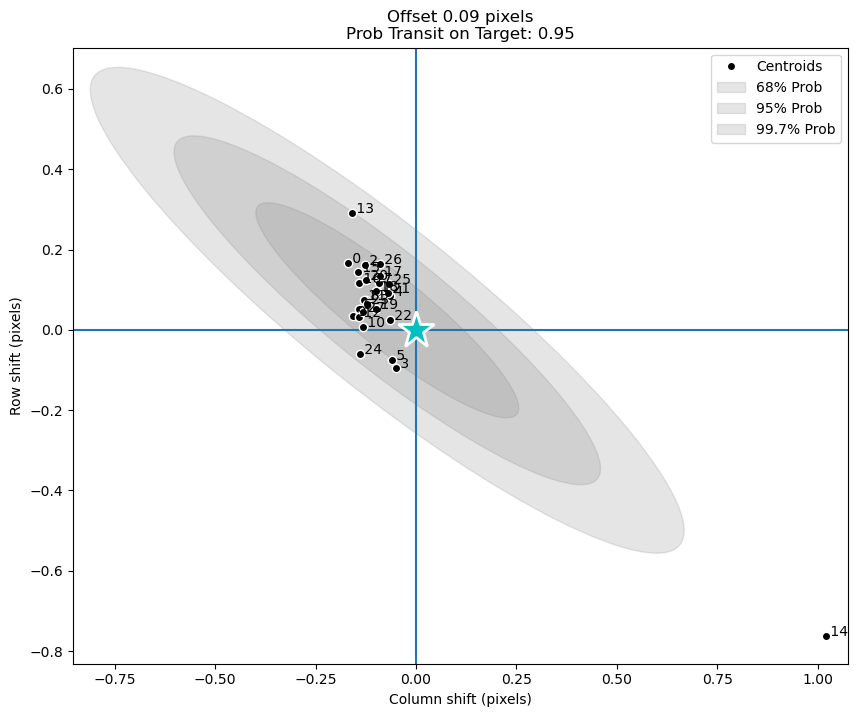

In [7]:
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord, ICRS

def get_gaia_info(ticid):
    """
    For a TIC ID integer return the gaia catalog information from MAST.
    """
    tic_data = Catalogs.query_criteria(ID = ticid, catalog="TIC")
    coord = SkyCoord(ra=tic_data['ra'], dec=tic_data['dec'], unit=(u.degree, u.degree), frame='icrs')
    gaia_r = Catalogs.query_object("%f, %f"%(tic_data['ra'], tic_data['dec']), radius = .05, catalog="Gaia")
    row = gaia_r[gaia_r['source_id'] == tic_data["GAIA"]]

    return row

ticid = 100100827 # TIC ID for WASP-18
gaia = get_gaia_info(ticid)
target_coord = SkyCoord(ra = gaia['ra'], dec = gaia['dec'], unit = (u.degree, u.degree), frame=ICRS) 
starloc_pix = wasp_18_tpf.wcs.world_to_pixel(target_coord) # WCS from wasp 18 tpf
starloc_pix = tuple(arr + 0.5 for arr in starloc_pix) # Need to adjust for imshow centering pixels at -0.5,-0.5

# run the centroid vetter with this tce and tpf
centroid_instance = vet.Centroid(starloc_pix=starloc_pix)
centroid_results = centroid_instance.run(wasp_18b_tce, wasp_18_tpf, plot=True)
centroid_results